# Description

- the Human Biomolecular Mapping Project (HuBMAP) Competition. The goal of this challenge is to segment the glomerular region in images of human kidney tissue from different tissue preparation pipelines.
- A glomerulus is a functional tissue unit (FTU): a three-dimensional block of cells centered on capillaries. That case, each cell in the block is within diffusion distance of any other cell in the same block.
- The data presented include 11 fresh-frozen and 9 formalin-fixed paraffin-embedded (FFPE) PAS kidney images: 8 sequences, 5+7 trials. They are each ~50k pixels in size and are saved as high resolution *tiff* images.
- In order to make such large images suitable for neural network training, they must be [sliced] (plz refer to the other code package). Depending on the size of the detected features, I would expect that the appropriate size of this data should be 1024x1024. However, for beginner's code and initial model development, this would be a challenge. Therefore, this kernel uses a 4 times lower resolution tile with 256x256 size. We can also run a higher resolution tile on the final setup (in preliminary tests it provided a 0.002-0.003 CV boost).
- In this kernel, an introductory code for *fast.ai* based on U-shaped networks (unset50, known as U-Net) is provided by me while some tips from previous segmentation contests are shared.

## Check if the corresponding folder already exists, e.g. 256size
- temp/hubmap-256x256/train/
- temp/hubmap-256x256/mask/

In [1]:
################################## 
DEBUG = True  # Debugging mode
SEED = 2020   # Set random seeds to keep the random number of experiments constant and make the experiment repeatable

NFOLDS = 5 # Fold number in non-debug time
TRAINED_FOLD = 0 # The number of folds already trained. Default is 0 fold.
### -------------------- ###
KAGGLE = False
COLAB = False
UNZIP = False
### -------------------- ###
sz = 256   # Set image size as 256,512,1024
bs = 4      # Set the batch size for a single input to the computer
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"   # Displayable GPU
import torch
#device_ids = [0,1,2] # Available GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Mutually exclusive
if KAGGLE:
    COLAB = False
    UNZIP = False
### -------------------- ###

In [1]:
# ### -------------------- ###
# COLAB = True
# UNZIP = False
# ### -------------------- ###
"""
if COLAB:
    # !pip3 install git+https://github.com/fastai/fastai.git
    # Mount a colab drive
    from google.colab import drive
    drive.mount('/content/drive')
    # Switching the working directory
    OS_DIR = '/content/drive/MyDrive/Kaggle/HuBMAP/code'
    import os
    os.chdir(OS_DIR)
    ## Run the lovasz script
    !python lovasz.py
"""

"\nif COLAB:\n    # !pip3 install git+https://github.com/fastai/fastai.git\n    # Mount a colab drive\n    from google.colab import drive\n    drive.mount('/content/drive')\n    # Switching the working directory\n    OS_DIR = '/content/drive/MyDrive/Kaggle/HuBMAP/code'\n    import os\n    os.chdir(OS_DIR)\n    ## Run the lovasz script\n    !python lovasz.py\n"

In [4]:
# # Create a folder to decompress images
# if COLAB & UNZIP:    
#     !mkdir ../temp/hubmap-256x256/train
#     !mkdir ../temp/hubmap-256x256/masks
#     !unzip  -d ../temp/hubmap-256x256/masks '../temp/hubmap-256x256/masks.zip'
#     !unzip  -d ../temp/hubmap-256x256/train '../temp/hubmap-256x256/train.zip'

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# 导入包
from fastai.vision.all import *
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import cv2
import gc
import random
from albumentations import *
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from lovasz import lovasz_hinge
#忽略警告
import warnings
warnings.filterwarnings("ignore")

In [6]:
# bs = 64
# nfolds = 4 # raw
# nfolds = 2 # First try to train 2 folds
# fold = 0
# SEED = 2020
# TRAIN = '../input/hubmap-256x256/train/' if not COLAB else '../temp/hubmap-256x256/train/'
# MASKS = '../input/hubmap-256x256/masks/' if not COLAB else '../temp/hubmap-256x256/masks/'
# LABELS = '../input/hubmap-kidney-segmentation/train.csv'
# NUM_WORKERS = 4

In [7]:
# bs = 64 # raw
# bs = 26 # bs32 size512 out of memory 
# nfolds = 4 # raw
nfolds = 2 if DEBUG else NFOLDS # First try to train 2 folds
train_fold = 1 if DEBUG else nfolds

fold = 0
# SEED = 2020
TRAIN = f'../input/hubmap-{sz}x{sz}/train/' if KAGGLE else f'../temp/hubmap-{sz}x{sz}/train/' # Set the address for reading data from the training image
MASKS = f'../input/hubmap-{sz}x{sz}/masks/' if KAGGLE else f'../temp/hubmap-{sz}x{sz}/masks/' # Set the address to read the data in the masked image
LABELS = '../input/hubmap-kidney-segmentation/train.csv'       #Set the read address of the tag
NUM_WORKERS = 4  # Number of workers created at once

model_base_name = f'seed_{SEED}_size_{sz}_nfolds_{nfolds}_trainfold_{train_fold}_'  # Name the saved model, the name is determined by the main parameters
print(f'model_base_name: {model_base_name}, batch_size: {bs}')


model_base_name: seed_2020_size_256_nfolds_2_trainfold_1_, batch_size: 4


In [8]:
#设置随机数
def seed_everything(seed):
    random.seed(seed) 
    # A random seed (or seed state, or just a seed) is a number (or vector) that is used to initialize a pseudo-random number generator.
    os.environ['PYTHONHASHSEED'] = str(seed) # Make experiments produce reproducible results
    np.random.seed(seed) # Get the maximum random number per run
    torch.manual_seed(seed) # Set the seed for generating random numbers
    torch.cuda.manual_seed(seed) # Set the seed for the current GPU to generate random numbers
    torch.backends.cudnn.deterministic = True # Make experiments produce reproducible results
    # the following line gives ~10% speedup
    # but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

# Data
One important thing here is the train/val split. To avoid possible leaks resulted by a similarity of tiles from the same images, it is better to keep tiles from each image together in train or in test.


In [9]:
# Set the mean and variance for different image size conditions
if sz==256:
    mean = np.array([0.65459856,0.48386562,0.69428385])
    std = np.array([0.15167958,0.23584107,0.13146145])
elif sz==512:
    mean = np.array([0.63759809, 0.4716141, 0.68231112])
    std = np.array([0.16475244, 0.22850685, 0.14593643])    
    # mean: [0.63759809 0.4716141  0.68231112] , std: [0.16475244 0.22850685 0.14593643]    
elif sz==1024:
    ### ------------- 1024 -------------
    mean = np.array([0.63711163, 0.47114376, 0.68181989])
    std = np.array([0.16736293, 0.23051024, 0.14848679])

In [10]:
# # https://www.kaggle.com/iafoss/256x256-images
# mean = np.array([0.65459856,0.48386562,0.69428385])
# std = np.array([0.15167958,0.23584107,0.13146145])
# Convert image data to tensor
def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1)) # Transpose the given image data
    return torch.from_numpy(img.astype(dtype, copy=False)) # Return the type of img

# Processing of data sets
class HuBMAPDataset(Dataset):
    def __init__(self, fold=fold, train=True, tfms=None):
        ids = pd.read_csv(LABELS).id.values   # Read labels from images
        kf = KFold(n_splits=nfolds,random_state=SEED,shuffle=True) # Multi-fold training of the data with NFOLD folds
        ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        self.fnames = [fname for fname in os.listdir(TRAIN) if fname.split('_')[0] in ids] # Read the name of the training file
        self.train = train
        self.tfms = tfms
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN,fname)), cv2.COLOR_BGR2RGB) # Convert images from BGR color space to RGB color space
        mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE) # Reads an masked image as a grayscale image
        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)  # For image enhancement
            img,mask = augmented['image'],augmented['mask'] # Get enhanced training
        return img2tensor((img/255.0 - mean)/std),img2tensor(mask) # Return the normalized tensor
    
def get_aug(p=1.0):
    return Compose([
        HorizontalFlip(),   # Horizontal flip
        VerticalFlip(),     # Vertical flip
        RandomRotate90(),   # Randomly flip 90 degrees several times
        
        # Scale and rotate images at an angle
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        OneOf([
            OpticalDistortion(p=0.3), # Optical distortion
            GridDistortion(p=.1),    # Mesh distortion
            IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        OneOf([
            HueSaturationValue(10,15,10), # Color saturation
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),  # Random brightness          
        ], p=0.3),
    ], p=p)

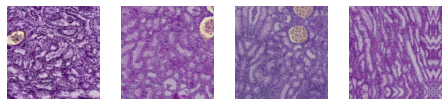

In [12]:
# example of train images with masks
# Examples of training images and masked images

# ds is the data enhanced data
ds = HuBMAPDataset(tfms=get_aug())
# dl
dl = DataLoader(ds,batch_size=bs ,shuffle=False,num_workers=NUM_WORKERS)
# Import the next batch of data after processing
imgs,masks = next(iter(dl))
# Output of enhanced and masked glomerular images
plt.figure(figsize=(16,16)) # Image size is 16*16
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8) # Standardize and convert the tensor to numpy format
    plt.subplot(8,8,i+1)
    plt.imshow(img,vmin=0,vmax=255) # Set the maximum and minimum values of image pixels
    plt.imshow(mask.squeeze().numpy(), alpha=0.2) # Compressing the dimensionality of the image
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None) # Image output adjustment
    
del ds,dl,imgs,masks

# Model
The model used in this kernel is based on a U-shape network (UneXt50, see image below), which I used in Severstal and Understanding Clouds competitions. The idea of a U-shape network is coming from a [Unet](https://arxiv.org/pdf/1505.04597.pdf) architecture proposed in 2015 for medical images: the encoder part creates a representation of features at different levels, while the decoder combines the features and generates a prediction as a segmentation mask. The skip connections between encoder and decoder allow us to utilize features from the intermediate conv layers of the encoder effectively, without a need for the information to go the full way through entire encoder and decoder. The latter is especially important to link the predicted mask to the specific pixels of the detected object. Later people realized that ImageNet pretrained computer vision models could drastically improve the quality of a segmentation model because of optimized architecture of the encoder, high encoder capacity (in contrast to one used in the original Unet), and the power of the transfer learning.

There are several important things that must be added to a Unet network, however, to make it able to reach competitive results with current state of the art approaches. First, it is **Feature Pyramid Network (FPN)**: additional skip connection between different upscaling blocks of the decoder and the output layer. So, the final prediction is produced based on the concatenation of U-net output with resized outputs of the intermediate layers. These skip-connections provide a shortcut for gradient flow improving model performance and convergence speed. Since intermediate layers have many channels, their upscaling and use as an input for the final layer would introduce a significant overhead in terms of the computational time and memory. Therefore, 3x3+3x3 convolutions are applied (factorization) before the resize to reduce the number of channels.

Another very important thing is the **Atrous Spatial Pyramid Pooling (ASPP) block** added between encoder and decoder. The flaw of the traditional U-shape networks is resulted by a small receptive field. Therefore, if a model needs to make a decision about a segmentation of a large object, especially for a large image resolution, it can get confused being able to look only into parts of the object. A way to increase the receptive field and enable interactions between different parts of the image is use of a block combining convolutions with different dilatations ([Atrous convolutions](https://arxiv.org/pdf/1606.00915.pdf) with various rates in ASPP block). While the original paper uses 6,12,18 rates, they may be customized for a particular task and a particular image resolution to maximize the performance. One more thing I added is using group convolutions in ASPP block to reduce the number of model parameters.

Finally, the decoder upscaling blocks are based on [pixel shuffle](https://arxiv.org/pdf/1609.05158.pdf) rather than transposed convolution used in the first Unet models. It allows to avoid artifacts in the produced masks. And I use [semisupervised Imagenet pretrained ResNeXt50](https://github.com/facebookresearch/semi-supervised-ImageNet1K-models) model as a backbone. In Pytorch it provides the performance of EfficientNet B2-B3 with much faster convergence for the computational cost and GPU RAM requirements of EfficientNet B0 (though, in TF EfficientNet is highly optimized and may be a good thing to use).

![](https://i.ibb.co/z5KxDzm/Une-Xt50-1.png)

In [13]:
# FPN-Create an FPN module
class FPN(nn.Module):
    def __init__(self, input_channels:list, output_channels:list):
        super().__init__()
        
        # ModuleLists are containers, because we can add modules to them
        self.convs = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(in_ch, out_ch*2, kernel_size=3, padding=1), # Convolution
             nn.ReLU(inplace=True), nn.BatchNorm2d(out_ch*2),                    # Activation function, normalized
             nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1))              # Convolution
            for in_ch, out_ch in zip(input_channels, output_channels)])          # Set the number of input and output channels for each layer of the model
        
    def forward(self, xs:list, last_layer):
        # Up-sampling
        hcs = [F.interpolate(c(x),scale_factor=2**(len(self.convs)-i),mode='bilinear') # Up-sampling by bilinear interpolation
               for i,(c,x) in enumerate(zip(self.convs, xs))] # Each layer in the enumeration model
        hcs.append(last_layer) # Add the layers in sequence
        return torch.cat(hcs, dim=1)

# Create a U-Net module
class UnetBlock(Module):
    def __init__(self, up_in_c:int, x_in_c:int, nf:int=None, blur:bool=False,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs) # Super resolution
        self.bn = nn.BatchNorm2d(x_in_c) # Normalization
        ni = up_in_c//2 + x_in_c
        nf = nf if nf is not None else max(up_in_c//2,32)
        self.conv1 = ConvLayer(ni, nf, norm_type=None, **kwargs)  # Convolutional layer 1
        self.conv2 = ConvLayer(nf, nf, norm_type=None,            # Convolutional layer 2
            xtra=SelfAttention(nf) if self_attention else None, **kwargs)  #  Self-attention
        self.relu = nn.ReLU(inplace=True)                         # Activation function

    def forward(self, up_in:Tensor, left_in:Tensor) -> Tensor:
        s = left_in
        up_out = self.shuf(up_in)
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1)) # Connect the results of the upsampling and downsampling correspondence layers (U-Net) and go through the activation function
        return self.conv2(self.conv1(cat_x))                    

# ASPP Submodule       
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, groups=1):
        super().__init__()
        # Set atrous convolution parameters
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                stride=1, padding=padding, dilation=dilation, bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(planes)# Normalization
        self.relu = nn.ReLU()           # Activation function

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x) # Perform atrous convolution
        x = self.bn(x)          # Normalization

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # Determine if the convolution is of known type
                torch.nn.init.kaiming_normal_(m.weight) # Weight initialization
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)# The weight parameter is filled with 1
                m.bias.data.zero_()   # The bias function is filled with 0
# Create and use ASPP modules
class ASPP(nn.Module):
    def __init__(self, inplanes=512, mid_c=256, dilations=[6, 12, 18, 24], out_c=None):
        super().__init__()
        self.aspps = [_ASPPModule(inplanes, mid_c, 1, padding=0, dilation=1)] + \
            [_ASPPModule(inplanes, mid_c, 3, padding=d, dilation=d,groups=4) for d in dilations]
        
        self.aspps = nn.ModuleList(self.aspps)   # Model list
        self.global_pool = nn.Sequential(nn.AdaptiveMaxPool2d((1, 1)),  #  Adaptive maximum pooling
                        nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),# Convolution
                        nn.BatchNorm2d(mid_c), nn.ReLU())               # Normalization
        out_c = out_c if out_c is not None else mid_c
        # The model sequence list neural network module is executed sequentially according to the incoming sucks
        self.out_conv = nn.Sequential(nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False), # Convolution
                                    nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)) # Normalization, activation function
        self.conv1 = nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False)   # Convolution
        self._init_weight() # Weight initialization

    def forward(self, x):
        x0 = self.global_pool(x) # Global pooling
        xs = [aspp(x) for aspp in self.aspps]
        x0 = F.interpolate(x0, size=xs[0].size()[2:], mode='bilinear', align_corners=True)# Bilinear interpolation
        x = torch.cat([x0] + xs, dim=1)
        return self.out_conv(x)
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [22]:
class UneXt50(nn.Module):
    def __init__(self, stride=1, **kwargs):
        super().__init__()
        # Encoder 
        
        # Read resnext model
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models',
                           'resnext50_32x4d_ssl')
        # Set the parameters of each layer of UneXt50
        self.enc0 = nn.Sequential(m.conv1, m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1),
                            m.layer1) #256
        self.enc2 = m.layer2 #512
        self.enc3 = m.layer3 #1024
        self.enc4 = m.layer4 #2048
        #aspp module and customized dilatations
        self.aspp = ASPP(2048,256,out_c=512,dilations=[stride*1,stride*2,stride*3,stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        
        # Decoder
        self.dec4 = UnetBlock(512,1024,256)
        self.dec3 = UnetBlock(256,512,128)
        self.dec2 = UnetBlock(128,256,64)
        self.dec1 = UnetBlock(64,64,32)
        self.fpn = FPN([512,256,128,64],[16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
    # Order of execution of UneXt 
    def forward(self, x):
        
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5),enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x

# Slice and dice the model into encoder and decoder parts by fastai
split_layers = lambda m: [list(m.enc0.parameters())+list(m.enc1.parameters())+
                list(m.enc2.parameters())+list(m.enc3.parameters())+
                list(m.enc4.parameters()),
                list(m.aspp.parameters())+list(m.dec4.parameters())+
                list(m.dec3.parameters())+list(m.dec2.parameters())+
                list(m.dec1.parameters())+list(m.fpn.parameters())+
                list(m.final_conv.parameters())]

# Loss and metric
The loss that works the best for image segmentation in most of the cases is [Lovász loss](https://arxiv.org/pdf/1705.08790.pdf), a differentiable surrogate of IoU. However, ReLU in it must be replaced by (ELU + 1), like I did [here](https://www.kaggle.com/iafoss/lovasz). Another trick is consideration of a symmetric Lovász loss: consider not only a predicted segmentation and a provided mask but also the inverse prediction and the inverse mask (predict mask for negative case).

In [23]:
def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1.0 - targets))

In [24]:
# dice-Calculation of coefficients
class Dice_soft(Metric):
    def __init__(self, axis=1): 
        self.axis = axis 
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred), learn.y)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()
    @property
    def value(self): return 2.0 * self.inter/self.union if self.union > 0 else None
    
# dice-Selection of adaptive thresholds
class Dice_th(Metric):
    def __init__(self, ths=np.arange(0.1,0.9,0.05), axis=1): 
        self.axis = axis
        self.ths = ths
    # inter and union parameter initialization    
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
    # Calculate the threshold value    
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred), learn.y)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        #Find the threshold value by case and return the largest of these thresholds
        dices = torch.where(self.union > 0.0, 
                2.0*self.inter/self.union, torch.zeros_like(self.union))
        return dices.max()

# Model evaluation

In [25]:
#iterator like wrapper that returns predicted and gt masks
# Model evaluation and inference testing
class Model_pred:
    def __init__(self, model, dl, tta:bool=True, half:bool=False):
        self.model = model
        self.dl = dl
        self.tta = tta
        self.half = half
    # Iterators    
    def __iter__(self):
        self.model.module.eval()  # Model iteration and model evaluation
        name_list = self.dl.dataset.fnames
        count=0
        with torch.no_grad():
            for x,y in iter(self.dl):
                x = x.to(device) # Feeding the model into the GPU
                if self.half: x = x.half()
                p = self.model(x)    # Implement model
                py = torch.sigmoid(p).detach() # Separation
                if self.tta:
                    #x,y,xy flips as TTA
                    flips = [[-1],[-2],[-2,-1]]
                    for f in flips:
                        p = self.model(torch.flip(x,f))
                        p = torch.flip(p,f)
                        py += torch.sigmoid(p).detach()
                    py /= (1+len(flips))
                if y is not None and len(y.shape)==4 and py.shape != y.shape:
                    py = F.upsample(py, size=(y.shape[-2],y.shape[-1]), mode="bilinear")
                py = py.permute(0,2,3,1).float().cpu()
                batch_size = len(py)
                for i in range(batch_size):
                    taget = y[i].detach().cpu() if y is not None else None
                    yield py[i],taget,name_list[count]
                    count += 1
                    
    def __len__(self):
        return len(self.dl.dataset)
# dice-Selection of adaptive thresholds 
class Dice_th_pred(Metric):
    def __init__(self, ths=np.arange(0.1,0.9,0.01), axis=1): 
        self.axis = axis
        self.ths = ths
        self.reset()
    # inter and union parameter initialization    
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
    # Calculate the threshold value    
    def accumulate(self,p,t):
        pred,targ = flatten_check(p, t)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    # Get the adaptive threshold
    def value(self):
        dices = torch.where(self.union > 0.0, 2.0*self.inter/self.union, 
                            torch.zeros_like(self.union))
        return dices
# Save the decoded image    
def save_img(data,name,out):
    data = data.float().cpu().numpy()
    img = cv2.imencode('.png',(data*255).astype(np.uint8))[1]
    out.writestr(name, img)

# Train

In [26]:
# import time
# s_time = time.strftime("%m-%d-%H-%M", time.localtime())
# base_save = f'../output/model_{sz}x{sz}/{model_base_name}_{s_time}_'
# print(base_save)

In [27]:
dice = Dice_th_pred(np.arange(0.2,0.7,0.01))
import torch.nn as nn
# for fold in range(nfolds):
# Read data from the training and evaluation datasets
for fold in range(train_fold):
    ds_t = HuBMAPDataset(fold=fold, train=True, tfms=get_aug())
    ds_v = HuBMAPDataset(fold=fold, train=False)
    data = ImageDataLoaders.from_dsets(ds_t,ds_v,bs=bs,
                num_workers=NUM_WORKERS,pin_memory=True).to(device)#.cuda(device=device_ids[0])#(device=device_ids[0])#to(device)
    
    model = UneXt50() # Inputting data into the model
    
    #if isinstance(model,nn.DataParallel):
    # model = model.module()
    # Using multiple GPUs
    # if torch.cuda.device_count() > 1:
        # print("Let's use", torch.cuda.device_count(), "GPUs!")
        # model = nn.DataParallel(UneXt50().cuda(), device_ids=[0, 1])
        # model = nn.DataParallel(model, device_ids=device_ids)#, device_ids=device_ids

        # model = model.module.to(device)#.cuda(device_ids[0])#device_ids
        # model = torch.nn.DataParallel(model, device_ids=[0,1], output_device=[0], dim=0)
    # Obtain the loss of the model
    learn = Learner(data, model, loss_func=symmetric_lovasz,
                metrics=[Dice_soft(),Dice_th()], 
                ## TypeError: __init__() got an unexpected keyword argument 'clip'
                # splitter=split_layers).to_fp16(clip=0.5) 
                splitter=split_layers).to_fp16()
    
    # Training from the ground up
    learn.freeze_to(-1) # Freezing partial layers
    for param in learn.opt.param_groups[0]['params']:
        param.requires_grad = False
    learn.fit_one_cycle(4, lr_max=1e-4)

    learn.unfreeze() # Stop freezing and continue training all layers
    # Annealing algorithm
    learn.fit_one_cycle(16, lr_max=slice(2e-5,2e-4),
        cbs=SaveModelCallback(monitor='dice_th',comp=np.greater))
    import time
    # Calculate the time of a cycle
    s_time = time.strftime("%m-%d-%H-%M", time.localtime())
    # Set the name of the saved model
    base_save = f'../output/model_{sz}x{sz}/{model_base_name}_{s_time}_'
    # Save model
    torch.save(learn.model.state_dict(),f'{base_save}model_{fold}.pth')
    
    #Evaluate predictions and save masked images for val's model
    mp = Model_pred(learn.model,learn.dls.loaders[1])
    # Save image
    with zipfile.ZipFile(f'{base_save}val_masks_tta.zip', 'a') as out:
        for p in progress_bar(mp):
            dice.accumulate(p[0],p[1])
            save_img(p[0],p[2],out)
    gc.collect()# Free memory

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,0.990320,0.960507,0.403819,0.658828,00:25
1,0.673458,1.165004,0.671377,0.788805,00:25
2,0.558828,0.858094,0.579221,0.808628,00:24
3,0.516298,1.068443,0.675052,0.824355,00:25


epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,0.476821,0.904658,0.707148,0.844749,00:39
1,0.524946,1.135000,0.763178,0.848648,00:38
2,0.482954,0.601238,0.749780,0.865563,00:38
3,0.404444,0.478220,0.845505,0.903735,00:39
4,0.343726,0.487483,0.822512,0.890318,00:37
5,0.420168,0.511262,0.717631,0.895659,00:38
6,0.328057,0.397109,0.886684,0.921875,00:38
7,0.267487,0.448439,0.891577,0.917732,00:39
8,0.289427,0.397249,0.878805,0.916202,00:38
9,0.289224,0.369684,0.867222,0.925811,00:38


Better model found at epoch 0 with dice_th value: 0.844749391078949.
Better model found at epoch 1 with dice_th value: 0.8486480116844177.
Better model found at epoch 2 with dice_th value: 0.865563154220581.
Better model found at epoch 3 with dice_th value: 0.9037354588508606.
Better model found at epoch 6 with dice_th value: 0.9218750596046448.
Better model found at epoch 9 with dice_th value: 0.9258105158805847.
Better model found at epoch 10 with dice_th value: 0.926978349685669.
Better model found at epoch 14 with dice_th value: 0.9279724359512329.


NameError: name '保存图像' is not defined

In [ ]:
dices = dice.value  # Find the value of dice coefficient
noise_ths = dice.ths # Find the dice threshold
best_dice = dices.max()# Get the maximum dice threshold
best_thr = noise_ths[dices.argmax()] # Find the threshold value when dice is maximum
# Drawing
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()

In [ ]:

# pid = os.getpid()
# !kill -9 $pi